# Librerías

In [ ]:
#!pip install pygam

In [1]:
# Cargar las librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#from pygam import LogisticGAM, s, f
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

# Cargar la data

In [2]:
# Carga de datos de archivos .csv
url = '/content/drive/MyDrive/Cursos/Coursera/Maestría en Inteligencia Analítica de Datos/202312/Proyecto aplicado en analítica de datos/Proyecto de Grado/datos/SECOP I filtro.txt'
secop1 = pd.read_csv(url, delimiter='|', dtype='str')

# Selecciona las columnas seleccionadas en el preprocesamiento
columnasSeleccionadas = ['UID', #1
                         'Anno Cargue SECOP', #2
                         'Anno Firma Contrato', #3
                         'Nivel Entidad', #4
                         'Orden Entidad', #5
                         'Nombre Entidad', #6
                         'NIT de la Entidad', #7
                         'Código de la Entidad', #8
                         'ID Modalidad', #9
                         'Modalidad de Contratacion', #10
                         'Estado del Proceso', #11
                         'ID Objeto a Contratar', #15
                         'Objeto a Contratar', #16
                         'Detalle del Objeto a Contratar', #17
                         'Municipio de Obtencion', #19
                         'Municipio de Entrega', #20
                         'Numero de Constancia', #23
                         'Numero de Proceso', #24
                         'Numero de Contrato', #25
                         'Cuantia Proceso', #26
                         'ID Grupo', #27
                         'Nombre Grupo', #28
                         'ID Familia', #29
                         'Nombre Familia', #30
                         'ID Clase', #31
                         'Nombre Clase', #32
                         'ID Adjudicacion', #33
                         'Tipo Identifi del Contratista', #34
                         'Identificacion del Contratista', #35
                         'Nom Razon Social Contratista', #36
                         'Dpto y Muni Contratista', #37
                         'Identific Representante Legal', #39
                         'Nombre del Represen Legal', #40
                         'Fecha de Firma del Contrato', #41
                         'Fecha Ini Ejec Contrato', #42
                         'Plazo de Ejec del Contrato', #43
                         'Rango de Ejec del Contrato', #44
                         'Tiempo Adiciones en Dias', #45
                         'Tiempo Adiciones en Meses', #46
                         'Fecha Fin Ejec Contrato', #47
                         'Cuantia Contrato', #49
                         'Valor Total de Adiciones', #50
                         'Valor Contrato con Adiciones', #51
                         'Objeto del Contrato a la Firma', #52
                         'Proponentes Seleccionados', #53
                         'Calificacion Definitiva', #54
                         'Es PostConflicto', #59
                         'Municipio Entidad', #67
                         'Departamento Entidad', #68
                         'Ultima Actualizacion', #69
                         'Fecha Liquidacion', #70
                         'Cumple Decreto 248', #71
                         'IncluyeBienesDecreto248' #72
                         ]


# Imputa valores NA
secop1['Fecha Ini Ejec Contrato'] = secop1['Fecha Ini Ejec Contrato'].fillna(secop1['Fecha de Cargue en el SECOP'])
#secop1['Cuantía Contrato'] = secop1['Cuantía Contrato'].fillna(secop1['Cuantía Proceso'])

# Cambia el tipo de las columnas numericas
columnasNumero = ['Cuantia Proceso', #26
                  'Plazo de Ejec del Contrato', #43
                  'Tiempo Adiciones en Dias', #45 ? sobra
                  'Tiempo Adiciones en Meses', #46 ? sobra
                  'Cuantia Contrato', #49
                  'Valor Total de Adiciones', #50 ? sobra
                  'Valor Contrato con Adiciones' #51 ? sobra
                  ]
secop1[columnasNumero] = secop1[columnasNumero].astype('int64')

# Convierte a formato fecha
#secop1['Ultima Actualizacion'] = pd.to_datetime(secop1['Ultima Actualizacion'], format='%d/%m/%Y')
secop1['Fecha Ini Ejec Contrato'] = pd.to_datetime(secop1['Fecha Ini Ejec Contrato'], format='%d/%m/%Y')
# Extrae año y mes
secop1['Anno Ini Ejec Contrato'] = secop1['Fecha Ini Ejec Contrato'].dt.year
secop1['Mes Ini Ejec Contrato'] = secop1['Fecha Ini Ejec Contrato'].dt.month

# Convierte años de 0 a 4 segun su posicion en cuetrenios desde 2016
secop1['Anno Ini Ejec Contrato'] = (secop1['Anno Ini Ejec Contrato']-2016)%4


# Crea Prorroga y Adicion
#secop1['Prorroga'] = secop1['Tiempo Adiciones en Dias'].apply(lambda x: 'Prorrogado' if x != 0 else 'No Prorrogado')
secop1['Prorroga'] = secop1['Tiempo Adiciones en Dias'] + secop1['Tiempo Adiciones en Meses']
secop1['Prorroga'] = secop1['Prorroga'].apply(lambda x: 1 if x != 0 else 0)
#secop1['Adicion'] = secop1['Valor Total de Adiciones'].apply(lambda x: 'Adicionado' if x != 0 else 'No Adicionado')
secop1['Adicion'] = secop1['Valor Total de Adiciones'].apply(lambda x: 1 if x != 0 else 0)


# Selecciona las columnas seleccionadas en el feature engineering
columnasSeleccionadas = ['Orden Entidad', #5
                         'Modalidad de Contratacion', #10
                         'Estado del Proceso', #11 adicional
                         #'Nombre Regimen de Contratacion', #14 ? igual que modalidad
                         'Objeto a Contratar', #16
                         'Municipio de Obtencion', #19
                         #'Anno de Cargue en el SECOP', #22 ?
                         #'Mes de Cargue en el SECOP', #22 ?
                         'Cuantia Proceso', #26
                         'Nombre Grupo', #28
                         'Tipo Identifi del Contratista', #34
                         'Dpto y Muni Contratista', #37
                         'Anno Ini Ejec Contrato', #42
                         'Mes Ini Ejec Contrato', # 42
                         'Plazo de Ejec del Contrato', #43
                         'Rango de Ejec del Contrato', #44
                         'Prorroga', #45 y 46
                         'Tiempo Adiciones en Dias', #45 ? perdida de informacion
                         'Tiempo Adiciones en Meses', #46 ? perdida de informacion
                         'Cuantia Contrato', #49
                         'Adicion', #50
                         'Valor Total de Adiciones', #50 ? sobra
                         'Valor Contrato con Adiciones', #51 ? sobra
                         #'Proponentes Seleccionados', #53
                         'Departamento Entidad' #68
                         ]

secop1 = secop1[columnasSeleccionadas]

"""
# Codificar las columnas categoricas
#secop1['Nivel Entidad'] = pd.factorize(secop1['Nivel Entidad'])[0]
secop1['Orden Entidad'] = pd.factorize(secop1['Orden Entidad'])[0] #5
secop1['Modalidad de Contratacion'] = pd.factorize(secop1['Modalidad de Contratacion'])[0] #10
secop1['Estado del Proceso'] = pd.factorize(secop1['Estado del Proceso'])[0] #11
secop1['Municipio de Obtencion'] = pd.factorize(secop1['Municipio de Obtencion'])[0] #11
secop1['Nombre Grupo'] = pd.factorize(secop1['Nombre Grupo'])[0] #28
secop1['Tipo Identifi del Contratista'] = pd.factorize(secop1['Tipo Identifi del Contratista'])[0] #34
secop1['Dpto y Muni Contratista'] = pd.factorize(secop1['Dpto y Muni Contratista'])[0] #37
secop1['Rango de Ejec del Contrato'] = pd.factorize(secop1['Rango de Ejec del Contrato'])[0] #44
#secop1['Municipio Entidad'] = pd.factorize(secop1['Municipio Entidad'])[0]
secop1['Departamento Entidad'] = pd.factorize(secop1['Departamento Entidad'])[0] #68
#secop1['Prorroga'] = pd.factorize(secop1['Prorroga'])[0]
#secop1['Adicion'] = pd.factorize(secop1['Adicion'])[0]
"""

# Eliminación filas con observaciones nulas
#secop1.dropna(inplace=True)
#secop1.head()

"\n# Codificar las columnas categoricas\n#secop1['Nivel Entidad'] = pd.factorize(secop1['Nivel Entidad'])[0]\nsecop1['Orden Entidad'] = pd.factorize(secop1['Orden Entidad'])[0] #5\nsecop1['Modalidad de Contratacion'] = pd.factorize(secop1['Modalidad de Contratacion'])[0] #10\nsecop1['Estado del Proceso'] = pd.factorize(secop1['Estado del Proceso'])[0] #11\nsecop1['Municipio de Obtencion'] = pd.factorize(secop1['Municipio de Obtencion'])[0] #11\nsecop1['Nombre Grupo'] = pd.factorize(secop1['Nombre Grupo'])[0] #28\nsecop1['Tipo Identifi del Contratista'] = pd.factorize(secop1['Tipo Identifi del Contratista'])[0] #34\nsecop1['Dpto y Muni Contratista'] = pd.factorize(secop1['Dpto y Muni Contratista'])[0] #37\nsecop1['Rango de Ejec del Contrato'] = pd.factorize(secop1['Rango de Ejec del Contrato'])[0] #44\n#secop1['Municipio Entidad'] = pd.factorize(secop1['Municipio Entidad'])[0]\nsecop1['Departamento Entidad'] = pd.factorize(secop1['Departamento Entidad'])[0] #68\n#secop1['Prorroga'] = pd

In [ ]:
secop1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135821 entries, 0 to 135820
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Orden Entidad                  135821 non-null  object
 1   Modalidad de Contratacion      135821 non-null  object
 2   Estado del Proceso             135821 non-null  object
 3   Objeto a Contratar             135821 non-null  object
 4   Municipio de Obtencion         135821 non-null  object
 5   Cuantia Proceso                135821 non-null  int64 
 6   Nombre Grupo                   135821 non-null  object
 7   Tipo Identifi del Contratista  135821 non-null  object
 8   Dpto y Muni Contratista        135821 non-null  object
 9   Anno Ini Ejec Contrato         135821 non-null  int64 
 10  Mes Ini Ejec Contrato          135821 non-null  int64 
 11  Plazo de Ejec del Contrato     135821 non-null  int64 
 12  Rango de Ejec del Contrato     135821 non-nu

In [ ]:
secop1.describe()

,Cuantia Proceso,Anno Ini Ejec Contrato,Mes Ini Ejec Contrato,Plazo de Ejec del Contrato,Prorroga,Tiempo Adiciones en Dias,Tiempo Adiciones en Meses,Cuantia Contrato,Adicion,Valor Total de Adiciones,Valor Contrato con Adiciones
count,1.358210e+05,135821.000000,135821.000000,135821.000000,135821.000000,135821.000000,135821.000000,1.358210e+05,135821.000000,1.358210e+05,1.358210e+05
mean,8.055539e+08,1.642721,7.649178,21.293953,0.107745,4.284529,0.154291,5.194422e+08,0.100677,4.350843e+07,5.629506e+08
std,1.204559e+10,1.097267,3.347910,59.360886,0.310059,24.941796,1.347305,6.280744e+09,0.300901,1.353830e+09,6.638070e+09
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1.600000e+07,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000,4.950000e+06,0.000000,0.000000e+00,4.993218e+06
50%,3.723510e+07,2.000000,8.000000,6.000000,0.000000,0.000000,0.000000,2.030769e+07,0.000000,0.000000e+00,2.049123e+07
75%,2.039998e+08,3.000000,11.000000,20.000000,0.000000,0.000000,0.000000,1.349976e+08,0.000000,0.000000e+00,1.400161e+08
max,2.680982e+12,3.000000,12.000000,5544.000000,1.000000,1551.000000,190.000000,8.523020e+11,1.000000,2.889530e+11,8.524664e+11


In [ ]:
secop1

,Orden Entidad,Modalidad de Contratacion,Estado del Proceso,Objeto a Contratar,Municipio de Obtencion,Cuantia Proceso,Nombre Grupo,Tipo Identifi del Contratista,Dpto y Muni Contratista,Anno Ini Ejec Contrato,...,Plazo de Ejec del Contrato,Rango de Ejec del Contrato,Prorroga,Tiempo Adiciones en Dias,Tiempo Adiciones en Meses,Cuantia Contrato,Adicion,Valor Total de Adiciones,Valor Contrato con Adiciones,Departamento Entidad
0,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Licitación Pública,Descartado,"Servicios de Edificación, Construcción de Inst...",Puerto Nariño,565193932,[F] Servicios,No Definido,No Definido,1,...,0,N,0,0,0,0,0,0,0,Amazonas
1,NACIONAL DESCENTRALIZADO,Selección Abreviada de Menor Cuantía (Ley 1150...,Liquidado,"Servicios de Edificación, Construcción de Inst...",Cartagena,124957683,[F] Servicios,Nit de Persona Jurídica,Bolívar,0,...,45,D,0,0,0,124957681,0,0,124957681,Bolívar
2,DISTRITO CAPITAL,Régimen Especial,Celebrado,"Servicios de Edificación, Construcción de Inst...",Bogotá D.C.,550000,[F] Servicios,Cédula de Ciudadanía,Bogotá D.C.,1,...,6,D,0,0,0,550000,0,0,550000,Bogotá DC
3,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Régimen Especial,Celebrado,"Componentes y Suministros para Estructuras, Ed...",No Definido,129310220,[D] Componentes y Suministros,Nit de Persona Jurídica,Bolívar,3,...,3,M,0,0,0,129310220,1,8022385,137332605,Bolívar
4,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Contratación Mínima Cuantía,Convocado,"Servicios de Edificación, Construcción de Inst...",Timbiquí,23000000,[F] Servicios,No Definido,No Definido,3,...,0,N,0,0,0,0,0,0,0,Cauca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135816,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Licitación Pública,Celebrado,"Servicios de Edificación, Construcción de Inst...",Bucaramanga,2969226856,[F] Servicios,Nit de Persona Jurídica,Santander,1,...,5,M,0,0,0,2969226856,0,0,2969226856,Santander
135817,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Contratación Mínima Cuantía,Celebrado,"Servicios de Edificación, Construcción de Inst...",Toledo,20000000,[F] Servicios,Nit de Persona Natural,Norte De Santander,2,...,8,D,0,0,0,19999538,0,0,19999538,Norte De Santander
135818,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Régimen Especial,Liquidado,"Servicios de Edificación, Construcción de Inst...",Fusagasugá,28510000,[F] Servicios,Cédula de Ciudadanía,Cundinamarca,0,...,45,D,1,23,0,28027000,1,2336050,30363050,Cundinamarca
135819,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 4,Contratación Mínima Cuantía,Celebrado,"Terrenos, Edificios, Estructuras y Vías",Clemencia,21723395,"[G] Terrenos, Edificios, Estructuras y vías",Nit de Persona Jurídica,Bolívar,2,...,15,D,0,0,0,21723395,0,0,21723395,Bolívar


In [ ]:
#!pip install pandas_profiling
#import pandas_profiling

#profile = secop1.profile_report(title='Pandas Profiling Report')
#profile.to_file(output_file='output.html')

## Visualizar la información

<Axes: xlabel='Estado del Proceso', ylabel='Cuantia Proceso'>

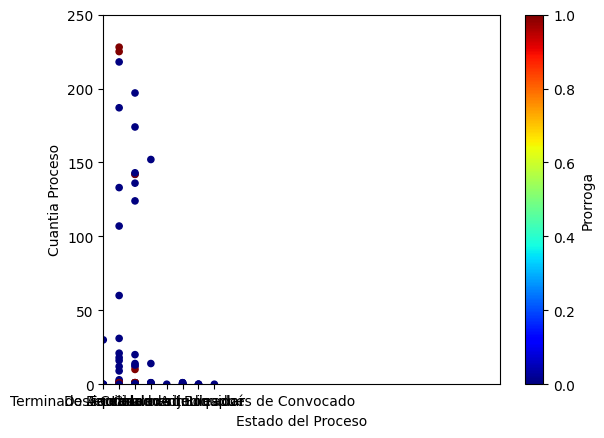

In [ ]:
# Gráfica del salario, años y hits
#plt.style.use('fivethirtyeight')
secop1.plot(kind='scatter', x='Estado del Proceso', y='Cuantia Proceso', c='Prorroga', colormap='jet', xlim=(0, 25), ylim=(0, 250))

## Definir las varibles del problema - Predictores y varible de respuesta

In [3]:
# Selección de variables predictoras para Prorroga
feature_cols = ['Orden Entidad',
                'Modalidad de Contratacion',
                'Estado del Proceso',
                #'Objeto a Contratar',
                'Municipio de Obtencion',
                'Cuantia Proceso',
                'Nombre Grupo',
                'Tipo Identifi del Contratista',
                'Dpto y Muni Contratista',
                'Anno Ini Ejec Contrato',
                'Mes Ini Ejec Contrato',
                'Plazo de Ejec del Contrato',
                'Rango de Ejec del Contrato',
                #'Prorroga',
                #'Tiempo Adiciones en Dias',
                #'Tiempo Adiciones en Meses',
                'Cuantia Contrato',
                #'Adicion',
                #'Valor Total de Adiciones',
                #'Valor Contrato con Adiciones',
                'Departamento Entidad'
                ]

# Separación de variables predictoras (X) y variable de interes (y)
secop1sample = secop1.sample(30000) # Se incia con un sample de 20k de los 135k registros
X = secop1sample[feature_cols]
y = (secop1sample['Adicion'])


# Convierte las variables categoricas a Dummies
X = pd.get_dummies(X, drop_first=True)

# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40, stratify=y)
print('Train:', y_train.shape[0], '\ny_train:')
print(y_train.value_counts())
print('\nTest:', y_test.shape[0], '\ny_test:')
print(y_test.value_counts())

Train: 20100 
y_train:
0    18072
1     2028
Name: Adicion, dtype: int64

Test: 9900 
y_test:
0    8901
1     999
Name: Adicion, dtype: int64


In [4]:
# Funcion para mostrar los resultados
def mostrar_resultados(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay(conf_matrix).plot()
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, y_pred))

# Modelos de Clasificación Lineal

## LDA

<Figure size 600x600 with 0 Axes>

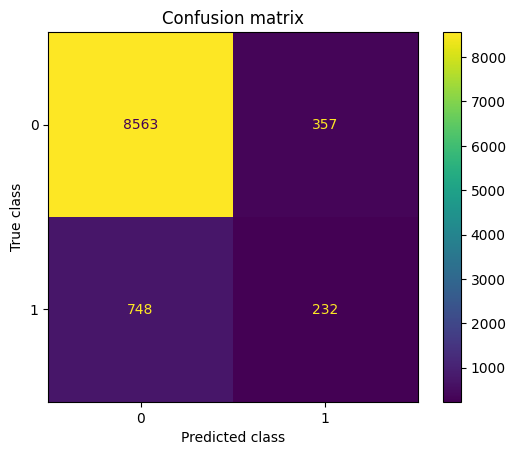

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      8920
           1       0.39      0.24      0.30       980

    accuracy                           0.89      9900
   macro avg       0.66      0.60      0.62      9900
weighted avg       0.87      0.89      0.88      9900



In [ ]:
# Estima modelo LDA con la muestra de entrenamiento
clfLDA = LinearDiscriminantAnalysis()
clfLDA.fit(X_train, y_train)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesLDA=clfLDA.predict(X_test)
prediccionesProbLDA=clfLDA.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesLDA)

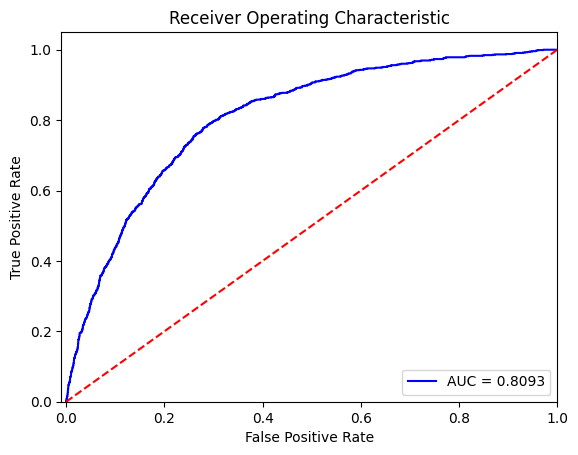

In [ ]:
# Curva ROC del modelo LDA
fpr, tpr, thresholds = roc_curve(y_test, clfLDA.decision_function(X_test), pos_label=clfLDA.classes_[1])
AUCLDA=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUCLDA)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 1991, 1: 1991})


<Figure size 600x600 with 0 Axes>

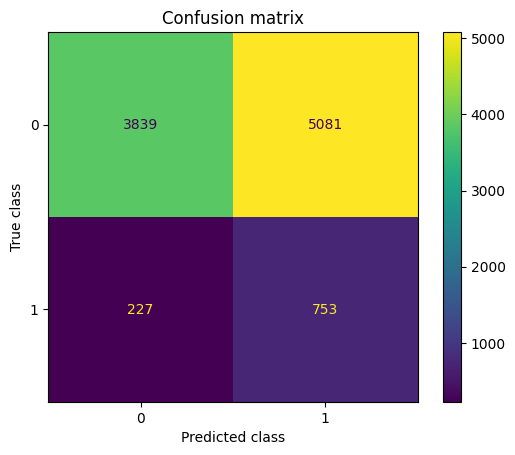

              precision    recall  f1-score   support

           0       0.94      0.43      0.59      8920
           1       0.13      0.77      0.22       980

    accuracy                           0.46      9900
   macro avg       0.54      0.60      0.41      9900
weighted avg       0.86      0.46      0.55      9900



In [ ]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Estima modelo LDA con la muestra de entrenamiento
clfLDA = LinearDiscriminantAnalysis()
clfLDA.fit(X_train_res, y_train_res)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesLDA=clfLDA.predict(X_test)
prediccionesProbLDA=clfLDA.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesLDA)

### Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution labels after resampling Counter({0: 18109, 1: 18109})


<Figure size 600x600 with 0 Axes>

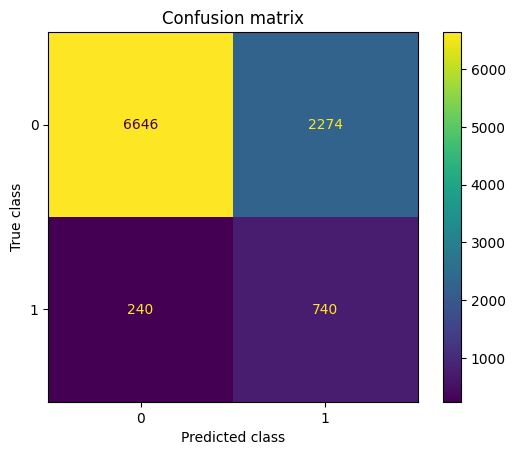

              precision    recall  f1-score   support

           0       0.97      0.75      0.84      8920
           1       0.25      0.76      0.37       980

    accuracy                           0.75      9900
   macro avg       0.61      0.75      0.61      9900
weighted avg       0.89      0.75      0.79      9900



In [ ]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Estima modelo LDA con la muestra de entrenamiento
clfLDA = LinearDiscriminantAnalysis()
clfLDA.fit(X_train_res, y_train_res)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesLDA=clfLDA.predict(X_test)
prediccionesProbLDA=clfLDA.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesLDA)

### Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 16061, 1: 16061})


<Figure size 600x600 with 0 Axes>

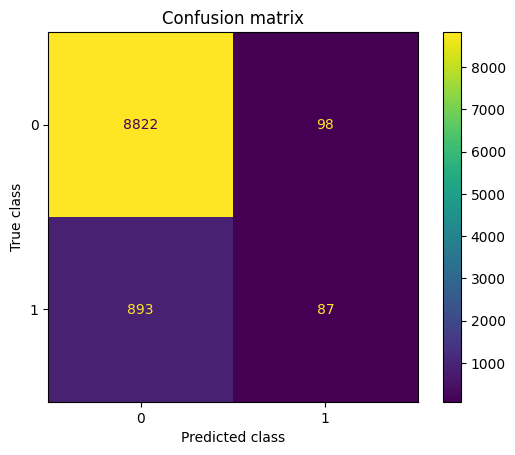

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8920
           1       0.47      0.09      0.15       980

    accuracy                           0.90      9900
   macro avg       0.69      0.54      0.55      9900
weighted avg       0.86      0.90      0.87      9900



In [ ]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Estima modelo LDA con la muestra de entrenamiento
clfLDA = LinearDiscriminantAnalysis()
clfLDA.fit(X_train_res, y_train_res)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesLDA=clfLDA.predict(X_test)
prediccionesProbLDA=clfLDA.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesLDA)

## QDA

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


<Figure size 600x600 with 0 Axes>

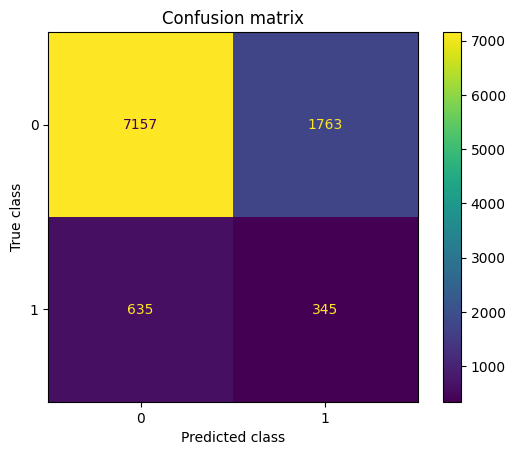

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      8920
           1       0.16      0.35      0.22       980

    accuracy                           0.76      9900
   macro avg       0.54      0.58      0.54      9900
weighted avg       0.84      0.76      0.79      9900



In [ ]:
# Estima modelo QDA con la muestra de entrenamiento
clfQDA = QuadraticDiscriminantAnalysis()
clfQDA.fit(X_train, y_train)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesQDA=clfQDA.predict(X_test)
prediccionesProbQDA=clfQDA.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesQDA)

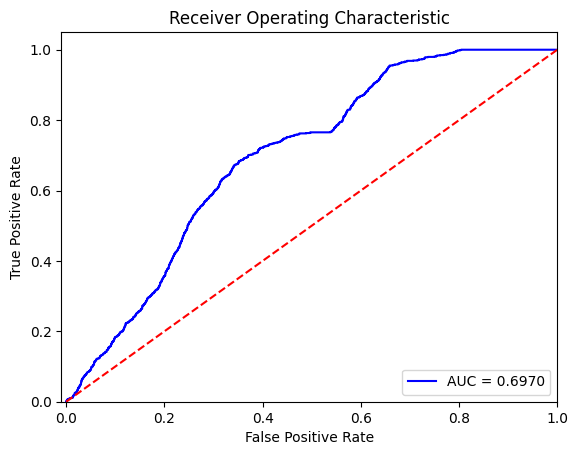

In [ ]:
# Curva ROC del modelo QDA
fpr, tpr, thresholds = roc_curve(y_test, clfQDA.decision_function(X_test), pos_label=clfQDA.classes_[1])
AUCQDA=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUCQDA)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 1991, 1: 1991})


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


<Figure size 600x600 with 0 Axes>

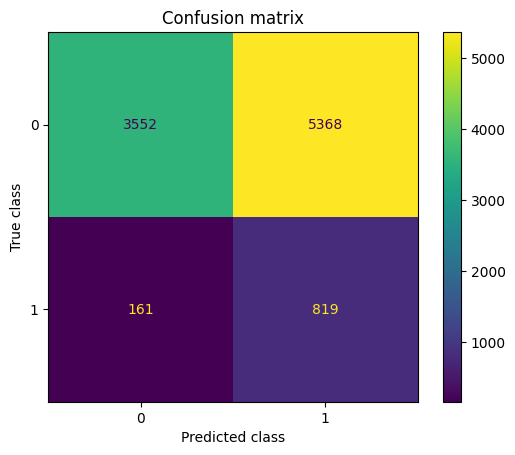

              precision    recall  f1-score   support

           0       0.96      0.40      0.56      8920
           1       0.13      0.84      0.23       980

    accuracy                           0.44      9900
   macro avg       0.54      0.62      0.40      9900
weighted avg       0.88      0.44      0.53      9900



In [ ]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Estima modelo QDA con la muestra de entrenamiento
clfQDA = QuadraticDiscriminantAnalysis()
clfQDA.fit(X_train_res, y_train_res)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesQDA=clfQDA.predict(X_test)
prediccionesProbQDA=clfQDA.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesQDA)

### Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution labels after resampling Counter({0: 18109, 1: 18109})


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


<Figure size 600x600 with 0 Axes>

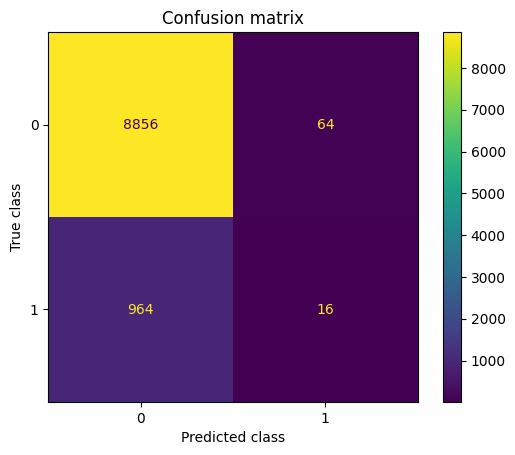

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      8920
           1       0.20      0.02      0.03       980

    accuracy                           0.90      9900
   macro avg       0.55      0.50      0.49      9900
weighted avg       0.83      0.90      0.85      9900



In [ ]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Estima modelo QDA con la muestra de entrenamiento
clfQDA = QuadraticDiscriminantAnalysis()
clfQDA.fit(X_train_res, y_train_res)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesQDA=clfQDA.predict(X_test)
prediccionesProbQDA=clfQDA.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesQDA)

### Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 16062, 1: 16062})


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


<Figure size 600x600 with 0 Axes>

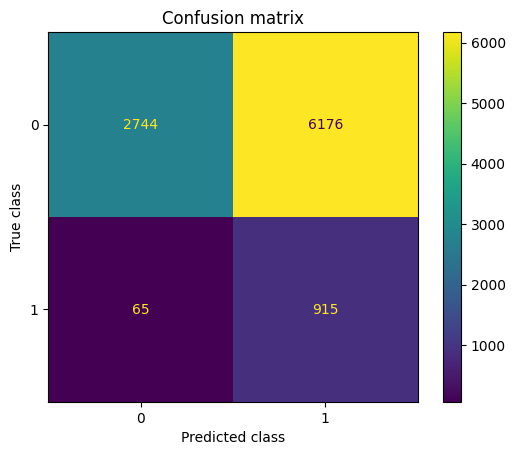

              precision    recall  f1-score   support

           0       0.98      0.31      0.47      8920
           1       0.13      0.93      0.23       980

    accuracy                           0.37      9900
   macro avg       0.55      0.62      0.35      9900
weighted avg       0.89      0.37      0.44      9900



In [ ]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Estima modelo QDA con la muestra de entrenamiento
clfQDA = QuadraticDiscriminantAnalysis()
clfQDA.fit(X_train_res, y_train_res)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesQDA=clfQDA.predict(X_test)
prediccionesProbQDA=clfQDA.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesQDA)

### Estrategia: Ensamble de Modelos con Balanceo

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/disc

<Figure size 600x600 with 0 Axes>

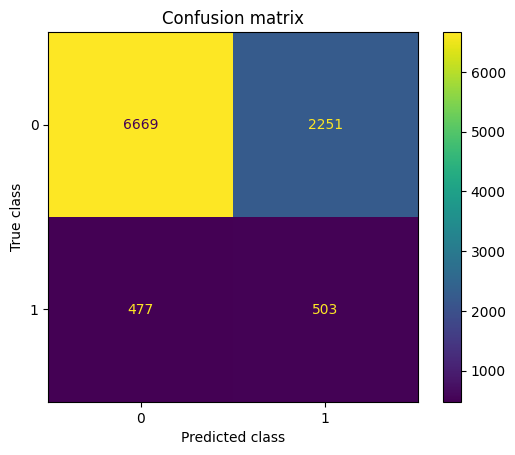

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      8920
           1       0.18      0.51      0.27       980

    accuracy                           0.72      9900
   macro avg       0.56      0.63      0.55      9900
weighted avg       0.86      0.72      0.77      9900



In [ ]:
# Ensamble con balanceo de árboles
bbc = BalancedBaggingClassifier(estimator=QuadraticDiscriminantAnalysis(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

## Naive Bayes

<Figure size 600x600 with 0 Axes>

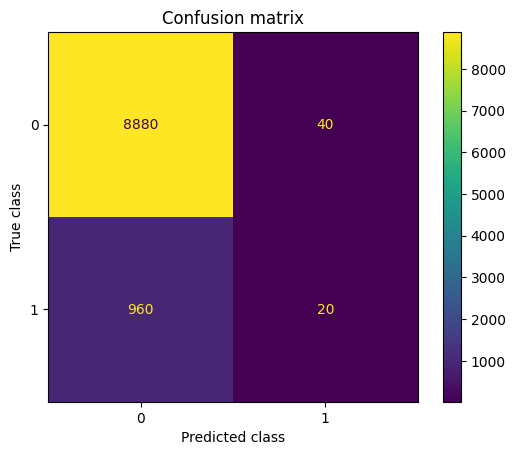

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8920
           1       0.33      0.02      0.04       980

    accuracy                           0.90      9900
   macro avg       0.62      0.51      0.49      9900
weighted avg       0.85      0.90      0.86      9900



In [ ]:
# Estima modelo NBC con la muestra de entrenamiento
clfNB = GaussianNB()
clfNB.fit(X_train, y_train)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesNB=clfNB.predict(X_test)
prediccionesProbNB=clfNB.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesNB)

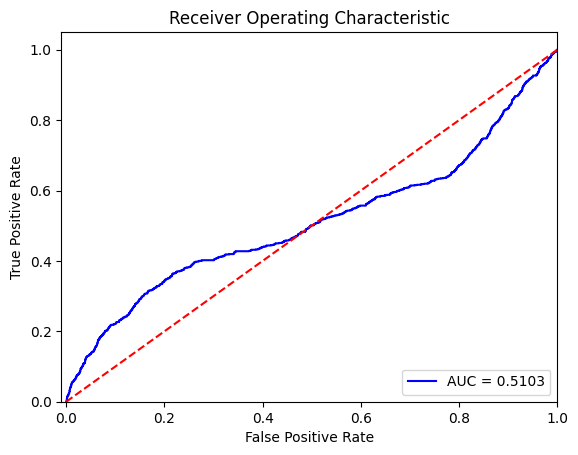

In [ ]:
# Curva ROC del modelo Naive Bayes
fpr, tpr, thresholds = roc_curve(y_test, clfNB.predict_proba(X_test)[:, 1], pos_label=clfNB.classes_[1])
AUCNB=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUCNB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 1991, 1: 1991})


<Figure size 600x600 with 0 Axes>

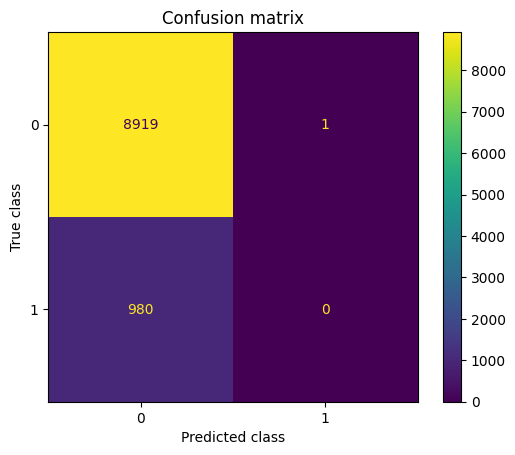

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8920
           1       0.00      0.00      0.00       980

    accuracy                           0.90      9900
   macro avg       0.45      0.50      0.47      9900
weighted avg       0.81      0.90      0.85      9900



In [ ]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Estima modelo NBC con la muestra de entrenamiento
clfNB = GaussianNB()
clfNB.fit(X_train_res, y_train_res)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesNB=clfNB.predict(X_test)
prediccionesProbNB=clfNB.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesNB)

### Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution labels after resampling Counter({0: 18109, 1: 18109})


<Figure size 600x600 with 0 Axes>

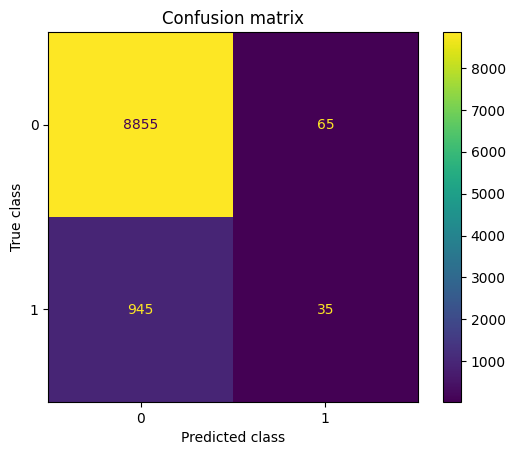

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      8920
           1       0.35      0.04      0.06       980

    accuracy                           0.90      9900
   macro avg       0.63      0.51      0.51      9900
weighted avg       0.85      0.90      0.86      9900



In [ ]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Estima modelo NBC con la muestra de entrenamiento
clfNB = GaussianNB()
clfNB.fit(X_train_res, y_train_res)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesNB=clfNB.predict(X_test)
prediccionesProbNB=clfNB.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesNB)

### Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 15982, 1: 15982})


<Figure size 600x600 with 0 Axes>

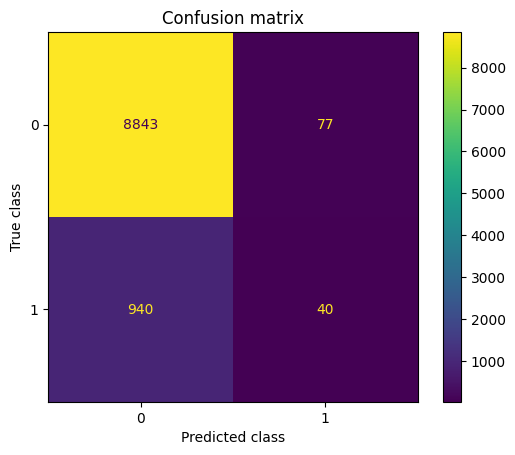

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      8920
           1       0.34      0.04      0.07       980

    accuracy                           0.90      9900
   macro avg       0.62      0.52      0.51      9900
weighted avg       0.85      0.90      0.86      9900



In [ ]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Estima modelo NBC con la muestra de entrenamiento
clfNB = GaussianNB()
clfNB.fit(X_train_res, y_train_res)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesNB=clfNB.predict(X_test)
prediccionesProbNB=clfNB.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesNB)

### Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

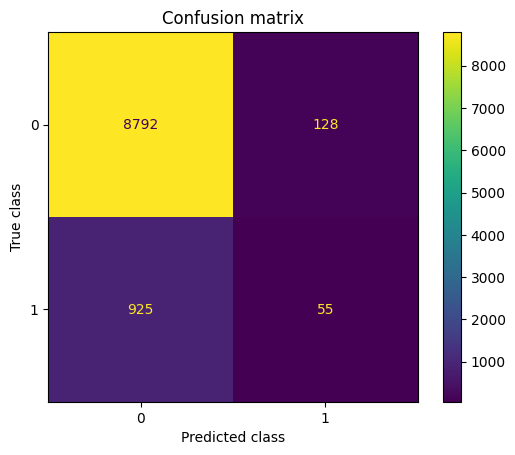

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      8920
           1       0.30      0.06      0.09       980

    accuracy                           0.89      9900
   macro avg       0.60      0.52      0.52      9900
weighted avg       0.84      0.89      0.86      9900



In [ ]:
# Ensamble con balanceo de árboles
bbc = BalancedBaggingClassifier(estimator=GaussianNB(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

# Modelos Lineales Generalizados

## Regresion Logistica

<Figure size 600x600 with 0 Axes>

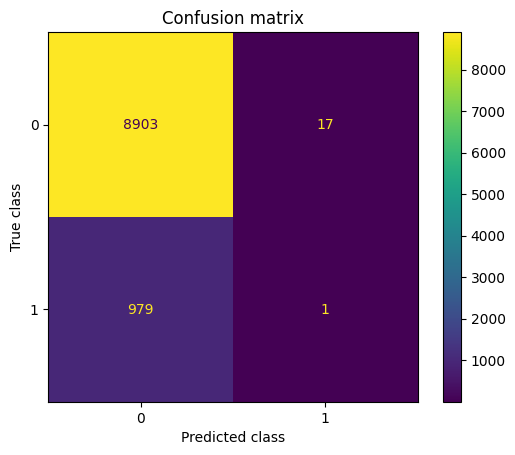

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8920
           1       0.06      0.00      0.00       980

    accuracy                           0.90      9900
   macro avg       0.48      0.50      0.47      9900
weighted avg       0.82      0.90      0.85      9900



In [ ]:
# Estima modelo Regresión Logística con la muestra de entrenamiento
clfRegLog= LogisticRegression(random_state=0,max_iter=10000)
clfRegLog.fit(X_train,y_train)

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesRegLog=clfRegLog.predict(X_test)
prediccionesProbRegLog=clfRegLog.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesRegLog)

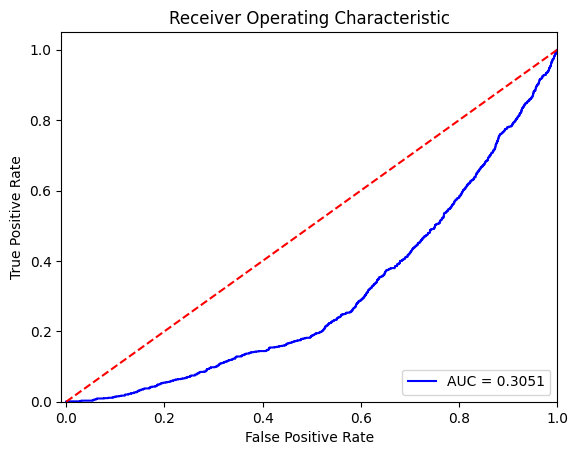

In [ ]:
# Curva ROC del modelo RL
fpr, tpr, thresholds = roc_curve(y_test, clfRegLog.decision_function(X_test), pos_label=clfRegLog.classes_[1])
AUCRL=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUCRL)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Modelos Aditivos

## GAM

In [ ]:
"""
# Ajuste modelo GAM para clasificción Limitado a 10 Ireaciones ya que sin Limitar No converge
gam = LogisticGAM(max_iter = 10).fit(X=X_train, y=y_train)
gam.summary()

# Estima la clase y las probabilidades de pertenecer a cada clase
prediccionesGAM = gam.predict(X=X_test)
prediccionesProbGAM=gam.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesGAM)
"""

In [ ]:
"""
# Gráfica de Curva ROC y AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediccionesProbGAM[:,1], pos_label=1)
AUCGam=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCGam)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
"""

# Modelos basados en particiones

## Árboles de decisión

DecisionTreeClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

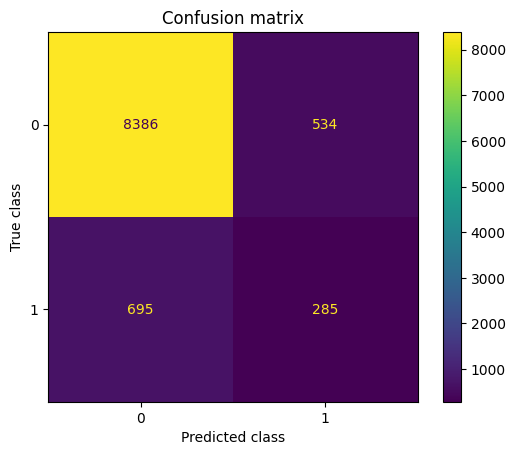

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      8920
           1       0.35      0.29      0.32       980

    accuracy                           0.88      9900
   macro avg       0.64      0.62      0.62      9900
weighted avg       0.87      0.88      0.87      9900



In [ ]:
# Arbol de decision 
clf = DecisionTreeClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Penalización para compensar

DecisionTreeClassifier(class_weight='balanced', random_state=1)


<Figure size 600x600 with 0 Axes>

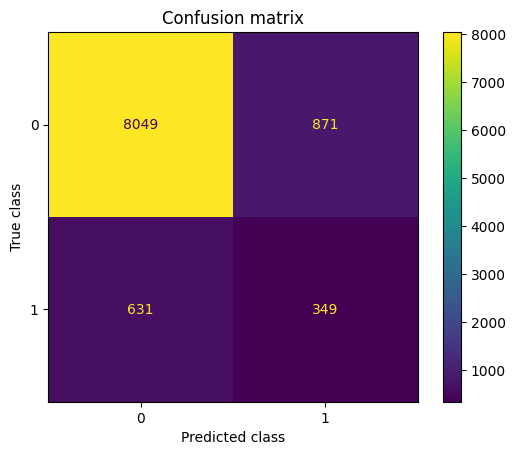

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      8920
           1       0.29      0.36      0.32       980

    accuracy                           0.85      9900
   macro avg       0.61      0.63      0.62      9900
weighted avg       0.86      0.85      0.86      9900



In [ ]:
# Arbol de decision
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced')
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 1991, 1: 1991})
DecisionTreeClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

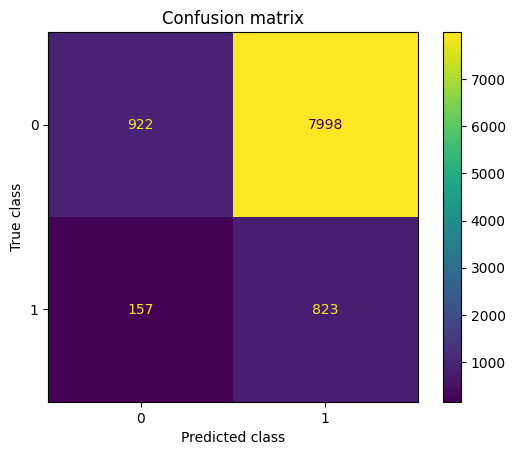

              precision    recall  f1-score   support

           0       0.85      0.10      0.18      8920
           1       0.09      0.84      0.17       980

    accuracy                           0.18      9900
   macro avg       0.47      0.47      0.18      9900
weighted avg       0.78      0.18      0.18      9900



In [ ]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = DecisionTreeClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution labels after resampling Counter({0: 18109, 1: 18109})
DecisionTreeClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

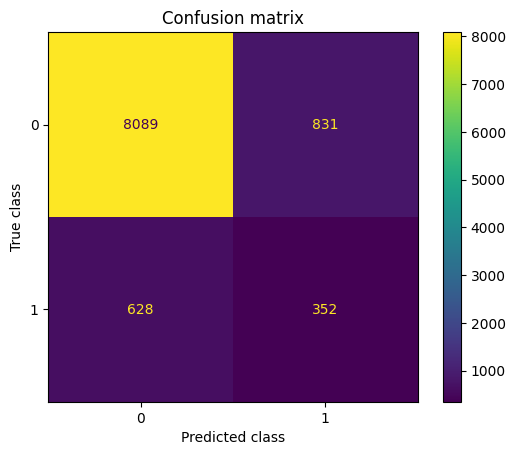

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      8920
           1       0.30      0.36      0.33       980

    accuracy                           0.85      9900
   macro avg       0.61      0.63      0.62      9900
weighted avg       0.87      0.85      0.86      9900



In [ ]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = DecisionTreeClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 16072, 1: 16072})
DecisionTreeClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

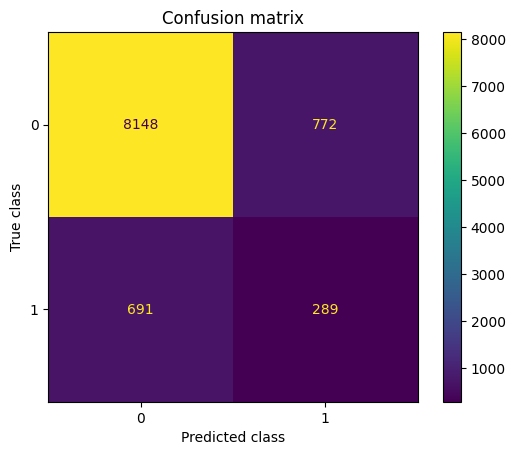

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      8920
           1       0.27      0.29      0.28       980

    accuracy                           0.85      9900
   macro avg       0.60      0.60      0.60      9900
weighted avg       0.86      0.85      0.85      9900



In [ ]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = DecisionTreeClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

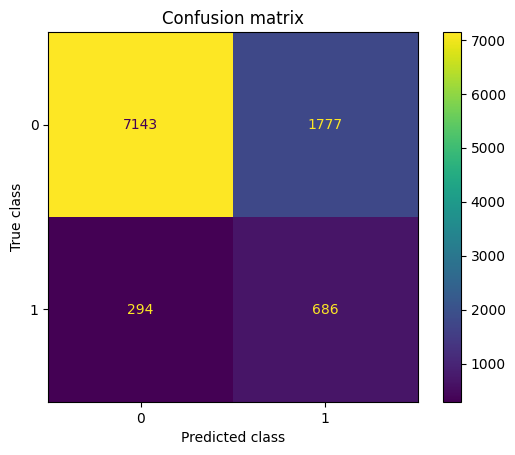

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      8920
           1       0.28      0.70      0.40       980

    accuracy                           0.79      9900
   macro avg       0.62      0.75      0.64      9900
weighted avg       0.89      0.79      0.83      9900



In [ ]:
# Ensamble con balanceo de árboles
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

In [ ]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

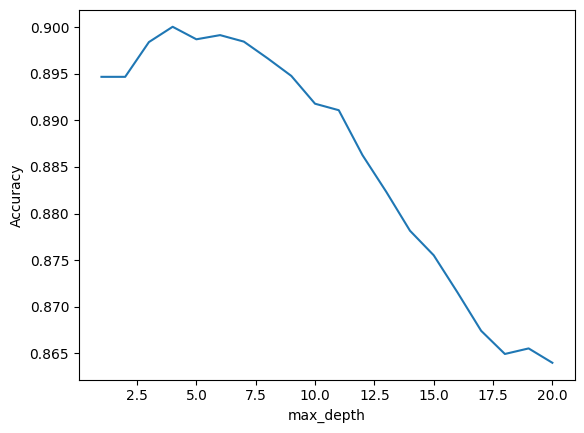

In [ ]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [ ]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.9000497512437811, 4)

DecisionTreeClassifier(max_depth=4, random_state=1)


<Figure size 600x600 with 0 Axes>

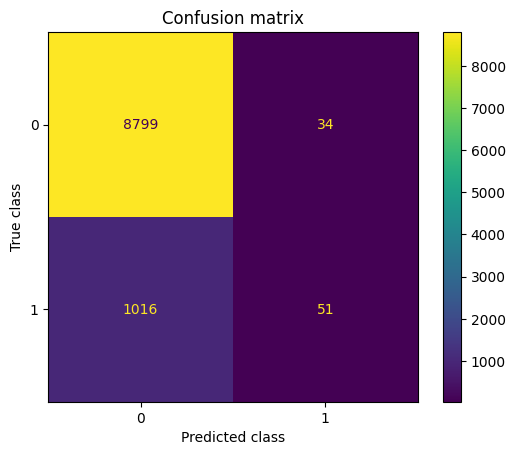

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      8833
           1       0.60      0.05      0.09      1067

    accuracy                           0.89      9900
   macro avg       0.75      0.52      0.52      9900
weighted avg       0.86      0.89      0.85      9900



In [ ]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

<Figure size 600x600 with 0 Axes>

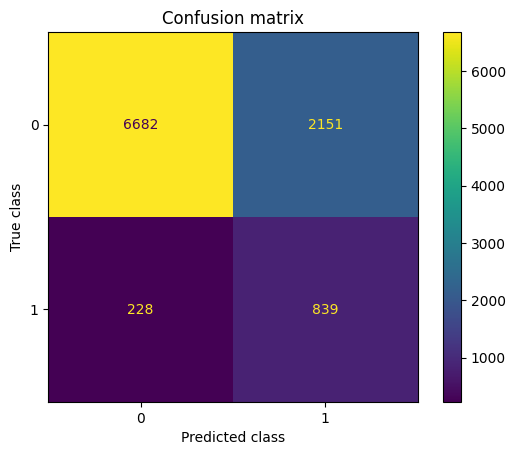

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      8833
           1       0.28      0.79      0.41      1067

    accuracy                           0.76      9900
   macro avg       0.62      0.77      0.63      9900
weighted avg       0.89      0.76      0.80      9900



In [ ]:
# Ensamble con balanceo de árboles
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4, random_state=1),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

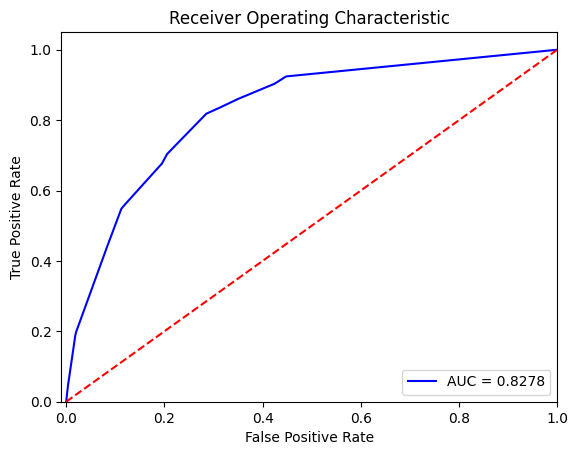

In [ ]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

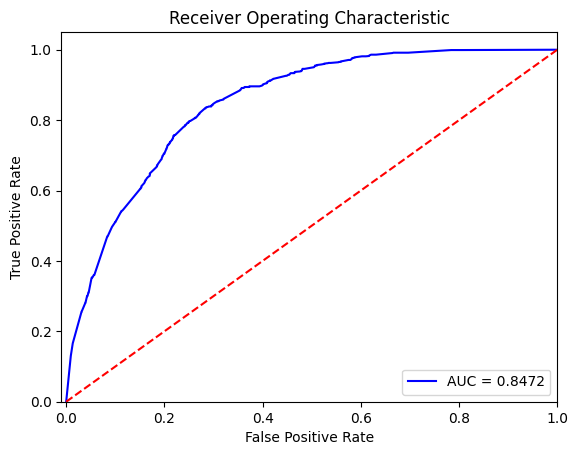

In [ ]:
# Curva ROC del modelo bbc
fpr, tpr, thresholds = roc_curve(y_test, bbc.predict_proba(X_test)[:,1], pos_label=bbc.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Importancia de las variables

In [ ]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

ValueError: ignored

In [ ]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.894800
std       0.003594
min       0.888667
25%       0.892750
50%       0.895167
75%       0.896917
max       0.900000
dtype: float64

## Random Forest

RandomForestClassifier()


<Figure size 600x600 with 0 Axes>

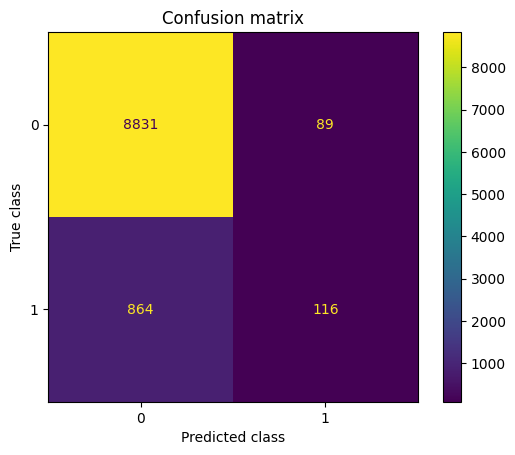

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8920
           1       0.57      0.12      0.20       980

    accuracy                           0.90      9900
   macro avg       0.74      0.55      0.57      9900
weighted avg       0.88      0.90      0.87      9900



In [ ]:
# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier()
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

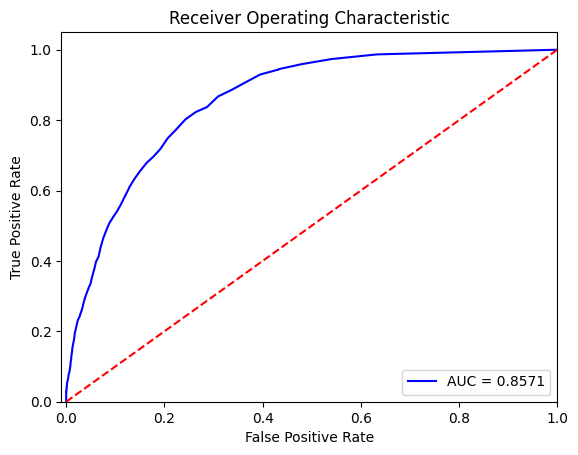

In [ ]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Impresión de desempeño del modelo usando la función cross_val_score  (más detalles en https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
pd.Series(cross_val_score(clf, X_train, y_train, cv=10)).describe()

count    10.000000
mean      0.904428
std       0.002051
min       0.900000
25%       0.904104
50%       0.904478
75%       0.905721
max       0.907463
dtype: float64

### Estrategia: Penalización para compensar

RandomForestClassifier(class_weight='balanced', random_state=1)


<Figure size 600x600 with 0 Axes>

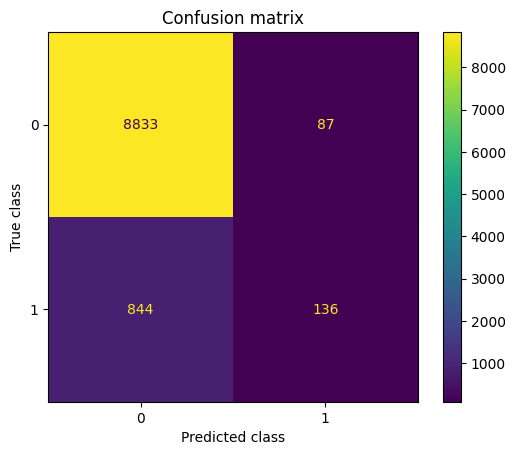

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8920
           1       0.61      0.14      0.23       980

    accuracy                           0.91      9900
   macro avg       0.76      0.56      0.59      9900
weighted avg       0.88      0.91      0.88      9900



In [ ]:
# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier(random_state=1, class_weight='balanced')
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

### Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 1991, 1: 1991})
RandomForestClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

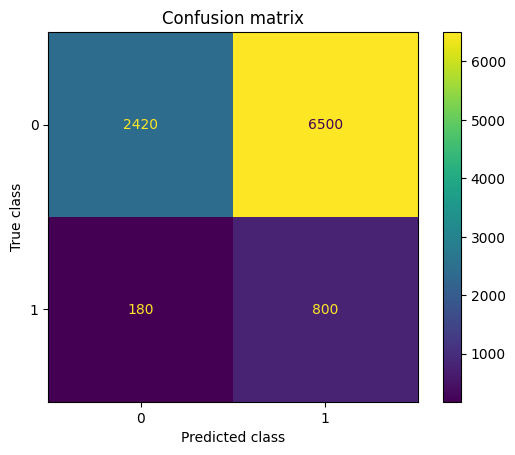

              precision    recall  f1-score   support

           0       0.93      0.27      0.42      8920
           1       0.11      0.82      0.19       980

    accuracy                           0.33      9900
   macro avg       0.52      0.54      0.31      9900
weighted avg       0.85      0.33      0.40      9900



In [ ]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = RandomForestClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution labels after resampling Counter({0: 18109, 1: 18109})
RandomForestClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

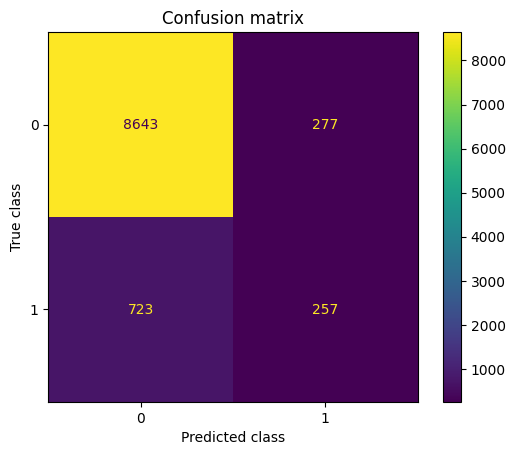

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      8920
           1       0.48      0.26      0.34       980

    accuracy                           0.90      9900
   macro avg       0.70      0.62      0.64      9900
weighted avg       0.88      0.90      0.89      9900



In [ ]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = RandomForestClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 16058, 1: 16058})
RandomForestClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

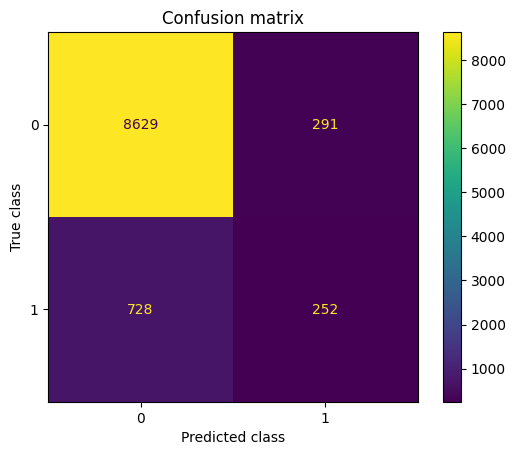

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      8920
           1       0.46      0.26      0.33       980

    accuracy                           0.90      9900
   macro avg       0.69      0.61      0.64      9900
weighted avg       0.88      0.90      0.88      9900



In [ ]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = RandomForestClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

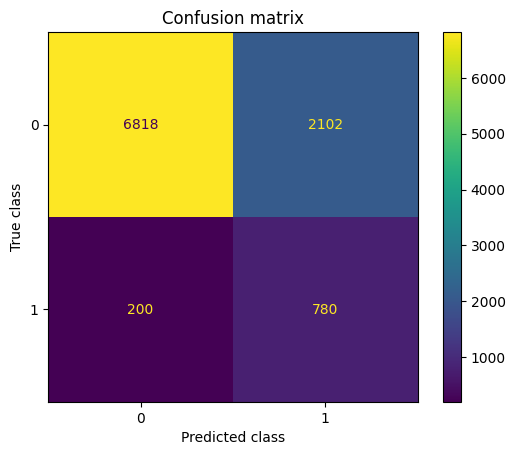

              precision    recall  f1-score   support

           0       0.97      0.76      0.86      8920
           1       0.27      0.80      0.40       980

    accuracy                           0.77      9900
   macro avg       0.62      0.78      0.63      9900
weighted avg       0.90      0.77      0.81      9900



In [ ]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=RandomForestClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

### Calibración de parámetros

#### Calibración de n_estimators

n_estimators es la cantidad de árboles a contruir dentro del bosque aleatorio.

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    print(estimator)
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


Text(0, 0.5, 'Accuracy')

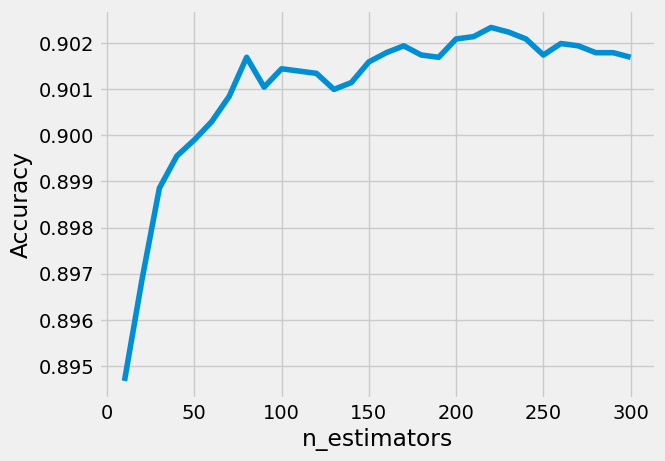

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

#### Calibracióm max_features

max_features es el número de variables que se deben considerar en cada árbol.

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    print(feature)
    clf = RandomForestClassifier(n_estimators=220, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0, 0.5, 'Accuracy')

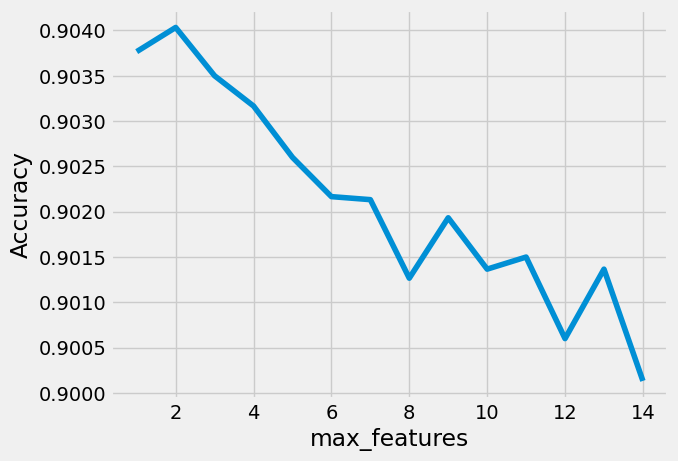

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

#### Implementación de un Random Forest con los mejores parámetros

RandomForestClassifier(max_features=2, n_estimators=120, n_jobs=-1,
                       random_state=1)


<Figure size 600x600 with 0 Axes>

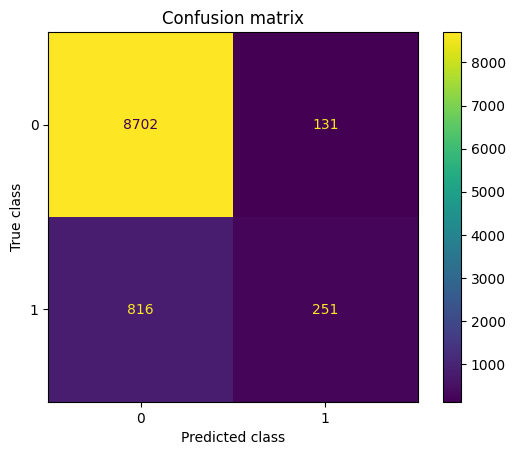

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8833
           1       0.66      0.24      0.35      1067

    accuracy                           0.90      9900
   macro avg       0.79      0.61      0.65      9900
weighted avg       0.89      0.90      0.88      9900



In [ ]:
# Definición del modelo con los parámetros max_features=6 y n_estimators=200 
clf = RandomForestClassifier(n_estimators=120, max_features=2, random_state=1, n_jobs=-1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

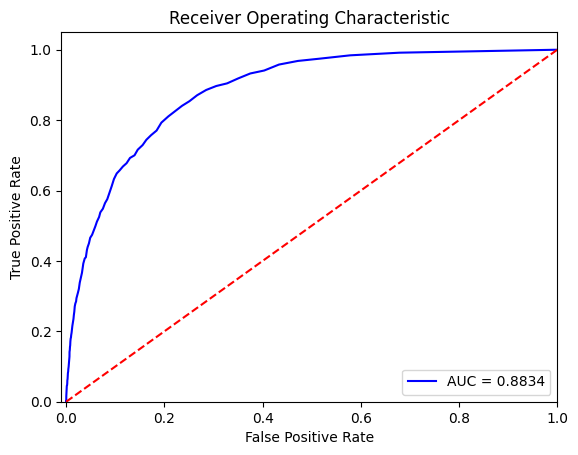

In [ ]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

ValueError: ignored

<Figure size 600x600 with 0 Axes>

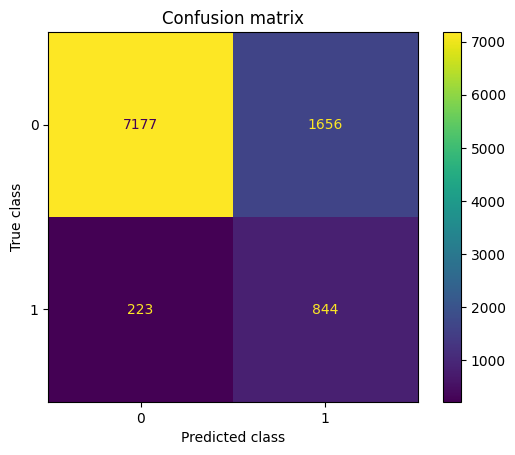

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      8833
           1       0.34      0.79      0.47      1067

    accuracy                           0.81      9900
   macro avg       0.65      0.80      0.68      9900
weighted avg       0.90      0.81      0.84      9900



In [ ]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=RandomForestClassifier(n_estimators=120, max_features=2, random_state=1, n_jobs=-1),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

## AdaBoost

AdaBoostClassifier()


<Figure size 600x600 with 0 Axes>

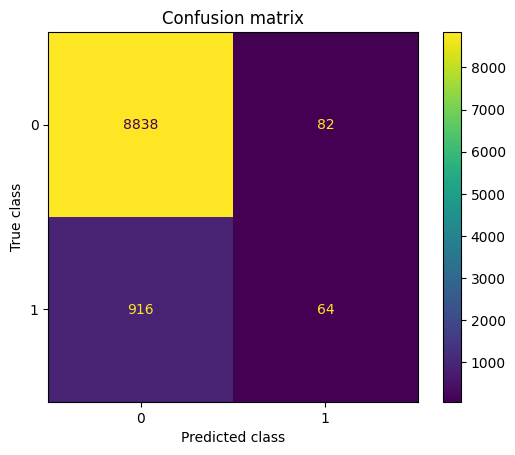

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8920
           1       0.44      0.07      0.11       980

    accuracy                           0.90      9900
   macro avg       0.67      0.53      0.53      9900
weighted avg       0.86      0.90      0.86      9900



In [ ]:
# Importación y definición de modelo AdaBoostClassifier
clf = AdaBoostClassifier()
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

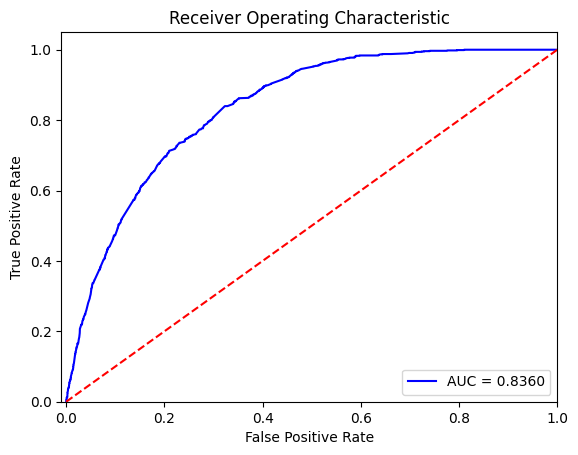

In [ ]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 1991, 1: 1991})
AdaBoostClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

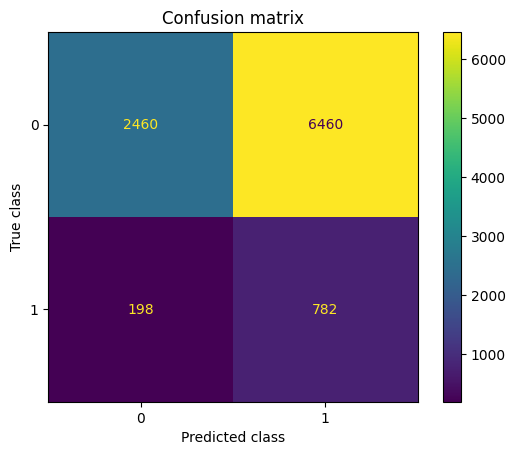

              precision    recall  f1-score   support

           0       0.93      0.28      0.42      8920
           1       0.11      0.80      0.19       980

    accuracy                           0.33      9900
   macro avg       0.52      0.54      0.31      9900
weighted avg       0.84      0.33      0.40      9900



In [ ]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = AdaBoostClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution labels after resampling Counter({0: 18109, 1: 18109})
AdaBoostClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

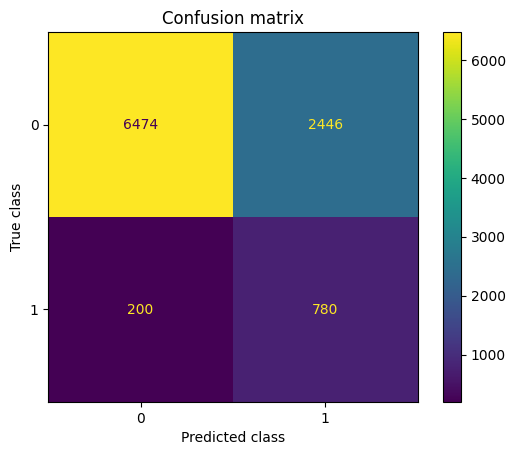

              precision    recall  f1-score   support

           0       0.97      0.73      0.83      8920
           1       0.24      0.80      0.37       980

    accuracy                           0.73      9900
   macro avg       0.61      0.76      0.60      9900
weighted avg       0.90      0.73      0.78      9900



In [ ]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = AdaBoostClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 16045, 1: 16045})
AdaBoostClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

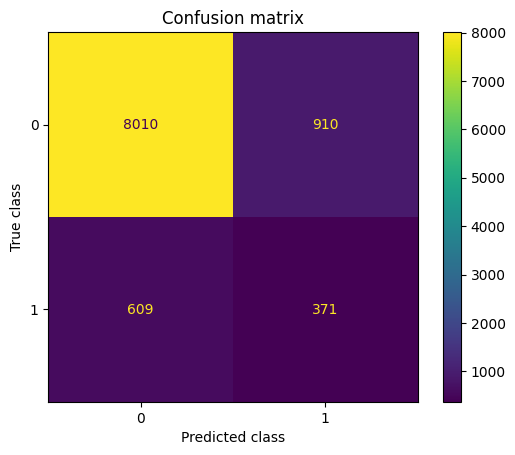

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      8920
           1       0.29      0.38      0.33       980

    accuracy                           0.85      9900
   macro avg       0.61      0.64      0.62      9900
weighted avg       0.87      0.85      0.86      9900



In [ ]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = AdaBoostClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

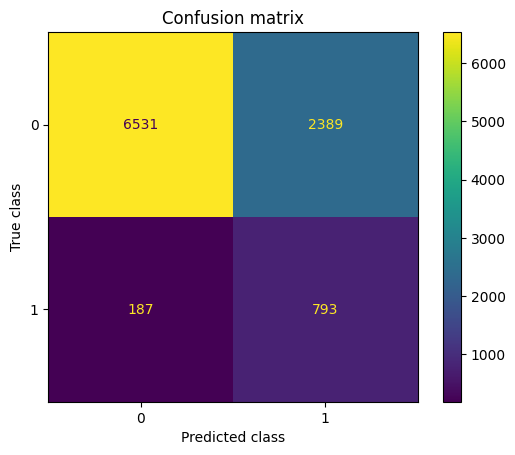

              precision    recall  f1-score   support

           0       0.97      0.73      0.84      8920
           1       0.25      0.81      0.38       980

    accuracy                           0.74      9900
   macro avg       0.61      0.77      0.61      9900
weighted avg       0.90      0.74      0.79      9900



In [ ]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=AdaBoostClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

## Gradient Boosting

GradientBoostingClassifier()


<Figure size 600x600 with 0 Axes>

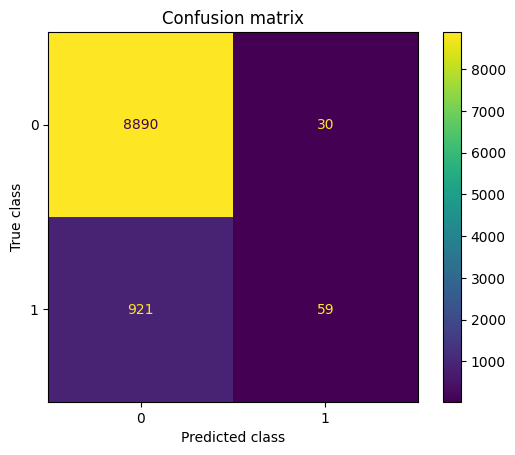

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      8920
           1       0.66      0.06      0.11       980

    accuracy                           0.90      9900
   macro avg       0.78      0.53      0.53      9900
weighted avg       0.88      0.90      0.87      9900



In [ ]:
# Importación y definición de modelo GradientBoostingClassifier
clf = GradientBoostingClassifier()
print(clf)

# Entrenamiento (fit) y desempeño del modelo GradientBoostingClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)
mostrar_resultados(y_test, y_pred)

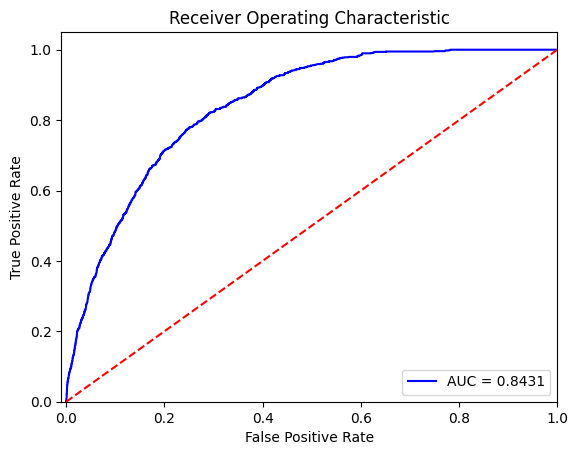

In [ ]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 1991, 1: 1991})
GradientBoostingClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

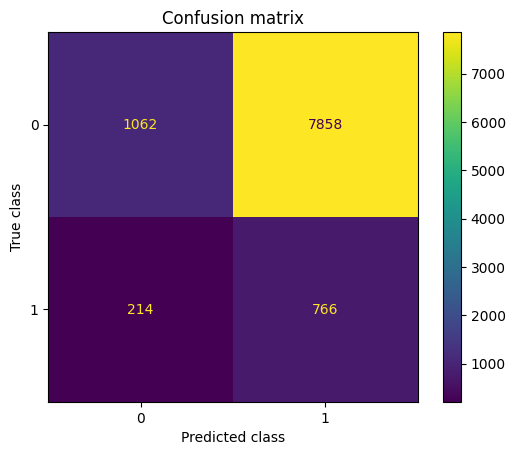

              precision    recall  f1-score   support

           0       0.83      0.12      0.21      8920
           1       0.09      0.78      0.16       980

    accuracy                           0.18      9900
   macro avg       0.46      0.45      0.18      9900
weighted avg       0.76      0.18      0.20      9900



In [ ]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = GradientBoostingClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution labels after resampling Counter({0: 18109, 1: 18109})
GradientBoostingClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

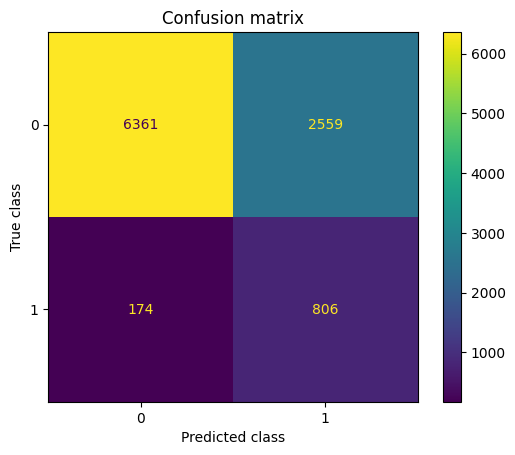

              precision    recall  f1-score   support

           0       0.97      0.71      0.82      8920
           1       0.24      0.82      0.37       980

    accuracy                           0.72      9900
   macro avg       0.61      0.77      0.60      9900
weighted avg       0.90      0.72      0.78      9900



In [ ]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = GradientBoostingClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18109, 1: 1991})
Distribution after resampling Counter({0: 16032, 1: 16032})
GradientBoostingClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

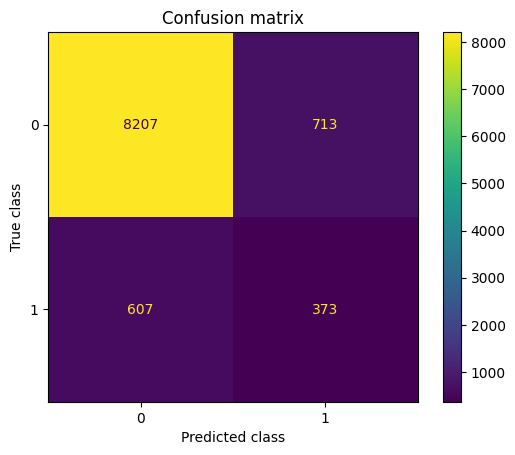

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      8920
           1       0.34      0.38      0.36       980

    accuracy                           0.87      9900
   macro avg       0.64      0.65      0.64      9900
weighted avg       0.87      0.87      0.87      9900



In [ ]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = GradientBoostingClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

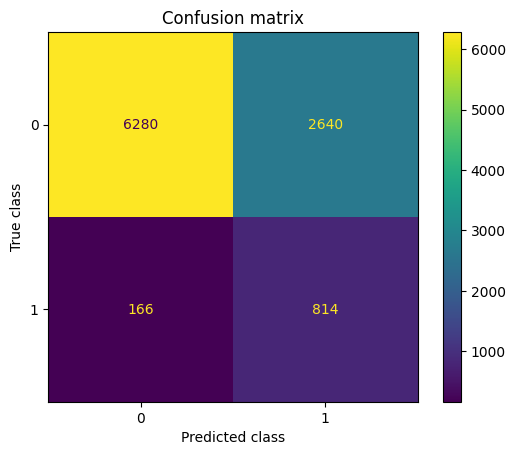

              precision    recall  f1-score   support

           0       0.97      0.70      0.82      8920
           1       0.24      0.83      0.37       980

    accuracy                           0.72      9900
   macro avg       0.60      0.77      0.59      9900
weighted avg       0.90      0.72      0.77      9900



In [ ]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=GradientBoostingClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

## Gradient XGBoost

In [ ]:
# Importación y definición de modelo XGBClassifier
clf = XGBClassifier()
print(clf)

# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)
mostrar_resultados(y_test, y_pred)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


ValueError: ignored

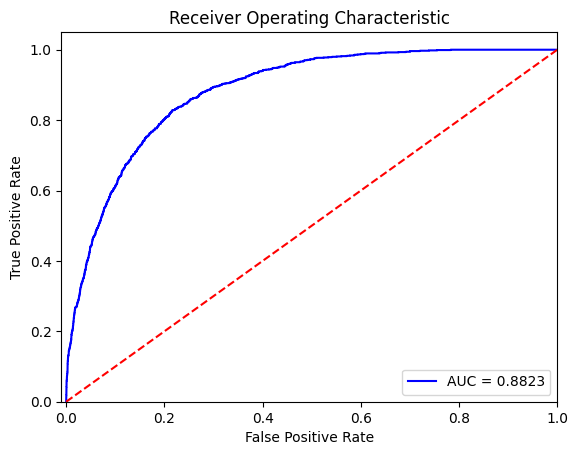

In [ ]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Estrategia: Subsampling en la clase mayoritaria

In [ ]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = XGBClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

Distribution before resampling Counter({0: 17933, 1: 2167})
Distribution after resampling Counter({0: 2167, 1: 2167})
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)


ValueError: ignored

### Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 17983, 1: 2117})
Distribution labels after resampling Counter({0: 17983, 1: 17983})
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)


<Figure size 600x600 with 0 Axes>

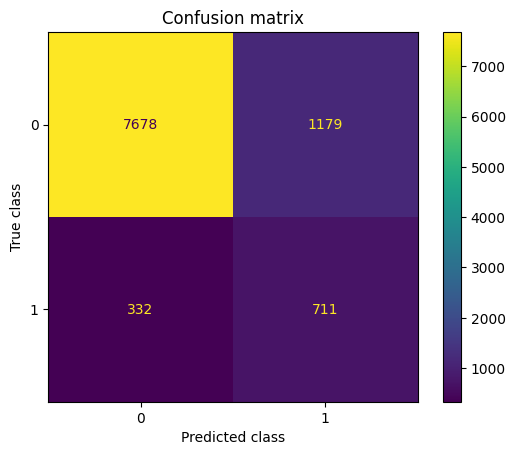

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      8857
           1       0.38      0.68      0.48      1043

    accuracy                           0.85      9900
   macro avg       0.67      0.77      0.70      9900
weighted avg       0.90      0.85      0.87      9900



In [ ]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = XGBClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 17983, 1: 2117})
Distribution after resampling Counter({0: 16056, 1: 16056})
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)


<Figure size 600x600 with 0 Axes>

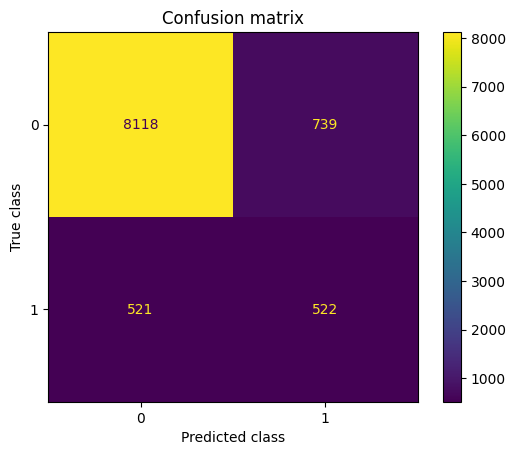

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      8857
           1       0.41      0.50      0.45      1043

    accuracy                           0.87      9900
   macro avg       0.68      0.71      0.69      9900
weighted avg       0.88      0.87      0.88      9900



In [ ]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = XGBClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

### Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

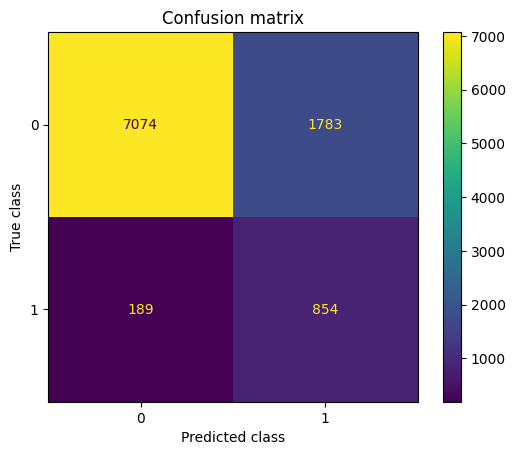

              precision    recall  f1-score   support

           0       0.97      0.80      0.88      8857
           1       0.32      0.82      0.46      1043

    accuracy                           0.80      9900
   macro avg       0.65      0.81      0.67      9900
weighted avg       0.91      0.80      0.83      9900



In [ ]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=XGBClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

# Modelos no paramétricos

## K-Vecinos

CALIBRACIÓN MODELO PARAMETROS: 1. NUMERO DE VECINOS

In [5]:
n_neighbors = 15
Vecinos = []
AUCKNN = []

for i in range(n_neighbors):
  knn = KNeighborsClassifier(i+1)
  knn.fit(X_train, y_train)
  prediccionesKNN = knn.predict(X_test)
  fpr, tpr, thresholds = roc_curve(y_test, prediccionesKNN, pos_label=1)
  AUC=auc(fpr, tpr)
  Vecinos.append(i+1)
  AUCKNN.append(AUC)

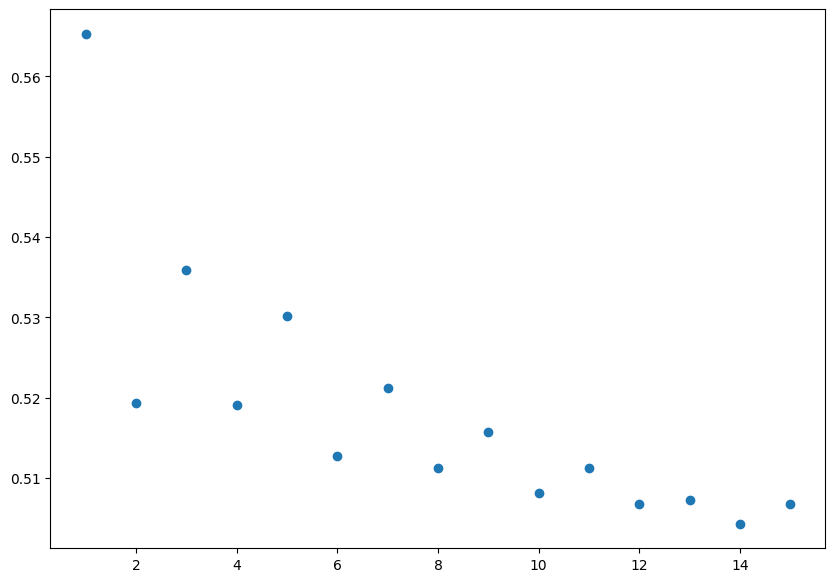

In [6]:
# Define tamaño de la figura
plt.figure(figsize=(10,7))

# Grafica de los F scores y variables por threshold
plt.scatter(Vecinos, AUCKNN)
plt.show()

<Figure size 600x600 with 0 Axes>

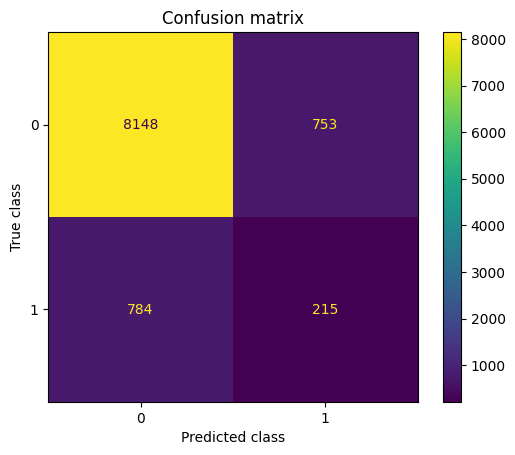

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      8901
           1       0.22      0.22      0.22       999

    accuracy                           0.84      9900
   macro avg       0.57      0.57      0.57      9900
weighted avg       0.84      0.84      0.84      9900



In [8]:
# Desarollo del Modelo escogiendo el # de Vecinos que maxima el AUC  en el punto anterior
n_neighbors = 1
 
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

# Estima las probabilidades de pertenecer a cada clase
prediccionesKNN = knn.predict(X_test)
prediccionProbKNN=knn.predict_proba(X_test)[:,0]

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesKNN)

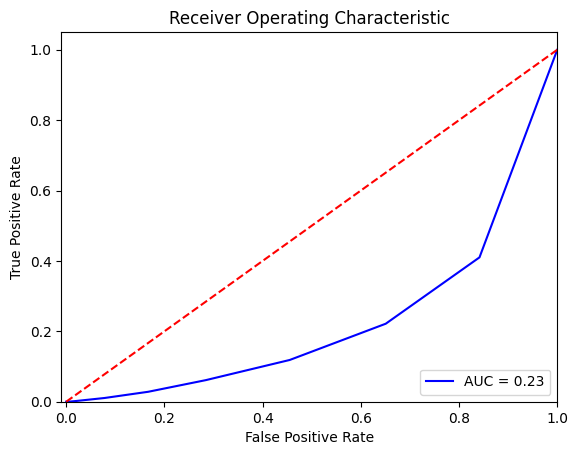

In [ ]:
# Gráfica de Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1], pos_label=0)
AUCKNN=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCKNN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# SVM

## SVM kernel Polinomial

In [ ]:
"""
# Estima el modelo de SVM con kernel polinomial
clfSVMPol = SVC(kernel='poly', probability=True, degree=2)
clfSVMPol.fit(X_train, y_train)

# Estima las probabilidades de pertenecer a cada clase
prediccionesSVMPol=clfSVMPol.predict(X_test)
prediccionesProbSVMPol=clfSVMPol.predict_proba(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, prediccionesSVMPol)
"""

In [ ]:
"""
# Métricas
# Gráfica de Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test,clfSVMPol.predict_proba(X_test)[:,1], pos_label=1)
AUCSVMPol=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCSVMPol)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
"""